# Introductory Guide

`provenance` is a Python library for function-level caching and provenance that aids in creating parsimonious pythonic pipelines&trade;. By wrapping functions in the `provenance` decorator computed results are cached across various stores (disk, S3, SFTP) and provenance (i.e. lineage) information is tracked and stored in an artifact repository. A central artifact repostiory can be used to enable production pipelines, team collaboration, and reproducible results.

What that means in practice is that you can easily keep track of how artifacts (models, features, or any object or file) are created, where they are used, and have a central place to store and share these artifacts. This basic plumbing is required (or at least desired!) in any machine learning pipeline or project. `provenance` can be used standalone along with a build server to run pipelines or in conjunction with more advanced workflow systems (e.g. [Airflow](http://airbnb.io/projects/airflow/), [Luigi](https://github.com/spotify/luigi)).

## Configuration

Before you can use `provenance` you need to configure it. The suggested way to do so is via the `load_config` function that takes a dictionary of settings. (ProTip: For a team environment take a look at [ymlconf](https://pypi.python.org/pypi/pymlconf) which does merging of configs, e.g. a shared config in a repo and a local one that isn't committed.)

We'll define our configuration map in YAML below. The config specifies a blobstore, where the cached values are stored, and an artifact repository, where the metadata is stored. In this example the cached values are stored on disk and the metadata is stored in a Postgres database.

In [1]:
%load_ext yamlmagic

In [2]:
%%yaml basic_config
blobstores:
    disk:
        type: disk
        cachedir: /tmp/provenance-intro-artifacts
        read: True
        write: True
        delete: True
artifact_repos:
    local:
        type: postgres
        db: postgresql://localhost/provenance-intro
        store: 'disk'
        read: True
        write: True
        delete: True
        # this option will create the database if it doesn't exist
        create_db: True
default_repo: local

<IPython.core.display.Javascript object>

In [3]:
import provenance as p


p.load_config(basic_config)

INFO  [alembic.runtime.migration] Context impl PostgresqlImpl.
INFO  [alembic.runtime.migration] Will assume transactional DDL.
INFO  [alembic.runtime.migration] Running stamp_revision  -> e0317ab07ba4


## Basic Example

To introduce the concepts we'll take a look at a small function that has been decorated with `provenance`.

Now lets define some decorated functions...

In [4]:
import time

@p.provenance()
def expensive_add(a, b):
    time.sleep(2)
    return a + b


@p.provenance()
def expensive_mult(a, b):
    time.sleep(2)
    return a * b

In [5]:
%%time
result = expensive_add(4, 3)
print(result)

7
CPU times: user 24.4 ms, sys: 14.8 ms, total: 39.2 ms
Wall time: 2.06 s


As expected, we have a slow addition function. To see the effect of the caching we can repeat the same function invocation:

In [6]:
%%time
result = expensive_add(4, 3)
print(result)

7
CPU times: user 4.06 ms, sys: 1.62 ms, total: 5.69 ms
Wall time: 5.61 ms


## Visualization

If you have used any caching/memoization decorator or library (e.g. `joblib`) then this is old hat to you. What is different is how the provenance of this result is recorded and how it can be accessed. For example, with the same result we can visualize the associated lineage:

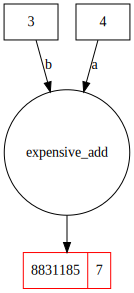

In [7]:
import provenance.vis as vis

vis.visualize_lineage(result)

## What is an artifact?

In the above visualization the `artifact` is outlined in red with the artifact `id` on the left and the `value` (result) on the right. How is this possible and what exactly is an `artifact`? Well, the `result` is not a raw `7` but rather is an `ArtifactProxy` which wraps the `7`.

In [8]:
result

<provenance.ArtifactProxy(88311853d7c885426fc5686543fe1412c62c0aac) 7 >

The hash in the parenthesis is the `id` of the artifact which is a function of the name of the function used and the inputs used to produce the value. 

All properties, methods, and operations called against this object will be proxied to the underlying value, `7` in this case. You can treat the result as you normally would:

In [9]:
result + 3

10

The one exception to this is the `artifact` property which returns the `Artifact`.

In [10]:
artifact = result.artifact
artifact

<provenance.Artifact(88311853d7c885426fc5686543fe1412c62c0aac)>

On this `artifact` is where you will find the provenance information for the value.

In [11]:
# What function what used to create artifact?
artifact.fn_module, artifact.fn_name

('__main__', 'expensive_add')

In [12]:
# What inputs were used?
artifact.inputs

{'kargs': {'a': 4, 'b': 3}, 'varargs': ()}

This information is what powered the visualization above.

Each artifact has additional information attached to it, such as the `id`, `value_id`, `value`, and `run_info`. `run_info` captures information about the environment when the artifact was created:

In [13]:
artifact.run_info

{'created_at': datetime.datetime(2017, 4, 30, 23, 59, 7, 29629),
 'host': {'cpu_count': 8,
  'machine': 'x86_64',
  'nodename': 'lambda',
  'platform': 'Darwin-16.5.0-x86_64-i386-64bit',
  'processor': 'i386',
  'release': '16.5.0',
  'system': 'Darwin',
  'version': 'Darwin Kernel Version 16.5.0: Fri Mar  3 16:52:33 PST 2017; root:xnu-3789.51.2~3/RELEASE_X86_64'},
 'id': 'fff2aa27f17612b97cb7b9443bdfe0c8377343f1',
 'process': {'cmdline': ['/Users/bmabey/anaconda/envs/provenance-dev/bin/python',
   '-m',
   'ipykernel',
   '-f',
   '/Users/bmabey/Library/Jupyter/runtime/kernel-536bbad6-5cee-4aca-bdcb-cdeed82f2f8c.json'],
  'cwd': '/Users/bmabey/w/provenance/docs/source',
  'exe': '/Users/bmabey/anaconda/envs/provenance-dev/bin/python3.5',
  'name': 'python3.5',
  'num_fds': 59,
  'num_threads': 9}}

You typically also want the `run_info` to include the `git` ref or build server job ID that was used to produce the artifact. This is easily done by using the provided `provenance.set_run_info_fn` hook. Please refer to the [API documenation](API.rst) for details.

## Loading Artifacts

Aside from calling decorating functions and having cached `artifact`s returned you can also explicitly load an `artifact` by it's `id`. This becomes useful in a team setting since you can have a shared store on S3, e.g. "Check out this amazing model I just built, load artifact 349ded4f...!". The other main usecase for this is in production settings. See the [Machine Learning Pipeline guide](ml-pipeline.ipynb) for more details on that.

In [14]:
# get the id of the artifact above
artifact_id = artifact.id

loaded_artifact = p.load_artifact(artifact_id)

loaded_artifact

<provenance.Artifact(88311853d7c885426fc5686543fe1412c62c0aac)>

You can inspect the `loaded_artifact` as done above or load the value into a proxy:

In [15]:
loaded_artifact.proxy()

<provenance.ArtifactProxy(88311853d7c885426fc5686543fe1412c62c0aac) 7 >

Alternatively, if you can load the proxy directly with `load_proxy`. `load_artifact` is still useful when you want the provenance and other metadata about an `artifact` but not the actual value.

In [16]:
p.load_proxy(artifact_id)

<provenance.ArtifactProxy(88311853d7c885426fc5686543fe1412c62c0aac) 7 >

## Multiple Functions Example

In any advanced workflow you will have a series of functions all pipelined together. For true provenance you will need to be able to track all artifacts to their source.  This is why the computed results of functions are returned as `ArtifactProxy`s, to enable the flow of artifacts to be tracked.

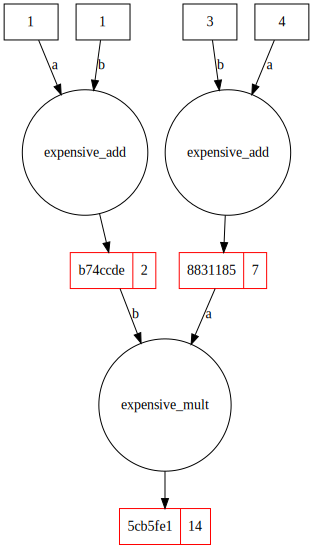

In [17]:
a1 = expensive_add(4, 3)
a2 = expensive_add(1, 1)

result = expensive_mult(a1, a2)

vis.visualize_lineage(result)

Note how the final artifact can be traced all the way back to the original inputs! As mentioned above this is enabled by the passing of the `ArtifactProxy` results, which means that for you to take advantage of this you must be passing the proxies throughout your entire pipeline. Best practice is to have your outer functions take basic Python data structures and then pass all resulting complex objects (e.g. scikit learn models) as `ArtifactProxy`s.

## Underlying Storage

Under the hood all of the artifacts are being recorded to the artifact repository we configured above. A repository is comprised of a store that records provenance and metadata and a blobstore that stores the serialized artifact (`joblib` serialization is the default). While you rarely would need to access the blobstore files directly, querying the DB directly is useful and is a hallmark of the library.

In [18]:
repo = p.get_default_repo()

db = repo._db_engine

import pandas as pd

pandas.read_sql("select * from artifacts", db)

,id,value_id,run_id,name,version,fn_module,fn_name,composite,value_id_duration,compute_duration,hash_duration,computed_at,added_at,input_artifact_ids,inputs_json,serializer,load_kwargs,dump_kwargs,custom_fields
0,88311853d7c885426fc5686543fe1412c62c0aac,bf68bf734f70b6643ce88133e90cf0f191aa704c,fff2aa27f17612b97cb7b9443bdfe0c8377343f1,__main__.expensive_add,0,__main__,expensive_add,False,0.000047,2.000509,0.000481,2017-04-30 23:59:07.044956,2017-04-30 23:59:09.068981,[],"{'__varargs': [], 'b': 3, 'a': 4}",joblib,None,None,{}
1,b74ccde8b53c0e02b4f269df65a39fd6be5191f7,9df9e3b99f954bd73e4314d3006e8d5b21bdcb84,fff2aa27f17612b97cb7b9443bdfe0c8377343f1,__main__.expensive_add,0,__main__,expensive_add,False,0.000049,2.004247,0.000450,2017-04-30 23:59:09.257366,2017-04-30 23:59:11.272746,[],"{'__varargs': [], 'b': 1, 'a': 1}",joblib,None,None,{}
2,5cb5fe1eeacbfe961bd03e63609ad64cf9c3ce12,483f2bffe8d13307d17ab5162facd02c09ff3b08,fff2aa27f17612b97cb7b9443bdfe0c8377343f1,__main__.expensive_mult,0,__main__,expensive_mult,False,0.000030,2.003946,0.000339,2017-04-30 23:59:11.279636,2017-04-30 23:59:13.293786,"[88311853d7c885426fc5686543fe1412c62c0aac, b74...","{'__varargs': [], 'b': {'id': 'b74ccde8b53c0e0...",joblib,None,None,{}


A few things to note here...

* The `input_artifact_ids` is an array of all of the artifact ids that were used in the input (even if nested in another data structure). This allows you to efficiently query for the progeny of a particular artifact.

* The `inputs_json` and `custom_fields` columns are stored as [JSONB in Postgres](https://www.postgresql.org/docs/9.5/static/functions-json.html) allowing you to query the nested structure via SQL. For example, you could find all the addition artifacts that were created with a particular argument:

In [19]:
pandas.read_sql("""select * from artifacts 
                   where fn_name = 'expensive_add'
                   and (inputs_json ->> 'a')::int IN (1, 4)
                """, db)

,id,value_id,run_id,name,version,fn_module,fn_name,composite,value_id_duration,compute_duration,hash_duration,computed_at,added_at,input_artifact_ids,inputs_json,serializer,load_kwargs,dump_kwargs,custom_fields
0,88311853d7c885426fc5686543fe1412c62c0aac,bf68bf734f70b6643ce88133e90cf0f191aa704c,fff2aa27f17612b97cb7b9443bdfe0c8377343f1,__main__.expensive_add,0,__main__,expensive_add,False,0.000047,2.000509,0.000481,2017-04-30 23:59:07.044956,2017-04-30 23:59:09.068981,[],"{'__varargs': [], 'b': 3, 'a': 4}",joblib,None,None,{}
1,b74ccde8b53c0e02b4f269df65a39fd6be5191f7,9df9e3b99f954bd73e4314d3006e8d5b21bdcb84,fff2aa27f17612b97cb7b9443bdfe0c8377343f1,__main__.expensive_add,0,__main__,expensive_add,False,0.000049,2.004247,0.000450,2017-04-30 23:59:09.257366,2017-04-30 23:59:11.272746,[],"{'__varargs': [], 'b': 1, 'a': 1}",joblib,None,None,{}


In [25]:
# the blobs are written to files with the names matching the hash of the content
!ls -l /tmp/provenance-intro-artifacts | head

total 32
-rw------- 1 bmabey staff  60 Apr 30 17:59 1106f8117e45a6736cf21222b4539f8aa4d16197
-rw------- 1 bmabey staff   5 Apr 30 17:59 483f2bffe8d13307d17ab5162facd02c09ff3b08
-rw------- 1 bmabey staff 195 Apr 30 17:59 5cb5fe1eeacbfe961bd03e63609ad64cf9c3ce12
-rw------- 1 bmabey staff  60 Apr 30 17:59 88311853d7c885426fc5686543fe1412c62c0aac
-rw------- 1 bmabey staff   5 Apr 30 17:59 9df9e3b99f954bd73e4314d3006e8d5b21bdcb84
-rw------- 1 bmabey staff   5 Apr 30 17:59 b4f270ccdb89ba3cc7d413c99e364b779676d72d
-rw------- 1 bmabey staff  60 Apr 30 17:59 b74ccde8b53c0e02b4f269df65a39fd6be5191f7
-rw------- 1 bmabey staff   5 Apr 30 17:59 bf68bf734f70b6643ce88133e90cf0f191aa704c


## Function Versioning

A potential pitfall of using `provenance` is getting stale cache results after updating your function. For example lets say we update our function definition:

In [21]:
@p.provenance()
def expensive_add(a, b):
    time.sleep(2)
    return a + b + a + b + a

In [22]:
%%time
expensive_add(4, 3)

CPU times: user 4.2 ms, sys: 1.95 ms, total: 6.15 ms
Wall time: 6.67 ms


<provenance.ArtifactProxy(88311853d7c885426fc5686543fe1412c62c0aac) 7 >

Noting the quick return time and incorrect result we see that we got an old (stale) cached result from our initial implementation. Rather than trying to determine if a function has been updated as `joblib` does the `provenance` library requires that you explicity version your functions to force new results to be computed. The rationale behind this is that it is quite hard (impossible in Python?) to tell when a funtion's definition or that of a helper function, which may be in another library, has semantically changed. For this reason the user of `provenance` must increment the version number of a function in the decorator:

In [23]:
# the default version is 0 so lets set it to 1
@p.provenance(version=1)
def expensive_add(a, b):
    time.sleep(2)
    return a + b + a + b + a

In [24]:
%%time
expensive_add(4, 3)

CPU times: user 12.6 ms, sys: 3.25 ms, total: 15.8 ms
Wall time: 2.02 s


<provenance.ArtifactProxy(1106f8117e45a6736cf21222b4539f8aa4d16197) 18 >

While this may seem onerous in practice this is not a big problem in a mature code base once people are aware of this. For rapidly changing functions you may want to consider using the `use_cache=False` option temporarily as you iterate on your function. See the docs on the decorator for more information.

## Next Steps

You now know the basics of the `provenance` library and can start using it now! Be aware that the `provenance` decorator takes a number of other options (such as `tags`) that can be quite helpful. Please refer to the [API documenation](API.rst) for details.